In [71]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('advertising').getOrCreate()

In [74]:
#Reading datasets
advertising = spark.read.json('AdDataset.json')
ad = spark.read.json('AdDataset_2.json')


In [75]:
#importing required libraries
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [76]:
#Visualizing data
advertising.show()
advertising.columns

ad.show()
ad.columns

+--------------------+-----------------+-----+--------------------+--------------------+------------------------+---+----+----------------+
|            Ad_Topic|             City|Click|             Country|Daily Internet Usage|Daily Time Spent on Site| ID|Male|       Timestamp|
+--------------------+-----------------+-----+--------------------+--------------------+------------------------+---+----+----------------+
|Cloned 5thgenerat...|      Wrightburgh|    0|             Tunisia|              256.09|                   68.95|  1|   0|27-03-2016 00:53|
|Monitored nationa...|        West Jodi|    0|               Nauru|              193.77|                   80.23|  2|   1|04-04-2016 01:39|
|Organic bottom-li...|         Davidton|    0|          San Marino|               236.5|                   69.47|  3|   0|13-03-2016 20:35|
|Triple-buffered r...|   West Terrifurt|    0|               Italy|              245.89|                   74.15|  4|   1|10-01-2016 02:31|
|Robust logistical..

['Age', 'Area Income', 'ID']

In [77]:
ad.describe().show()

+-------+------------------+------------------+------------------+
|summary|               Age|       Area Income|                ID|
+-------+------------------+------------------+------------------+
|  count|              1638|              1638|              1638|
|   mean|50.217948717948715|  51063.3769814653|             819.5|
| stddev|19.228160858771865|12757.313650973787|472.99418601077963|
|    min|                19|           13996.5|                 1|
|    max|                80|           79484.8|              1638|
+-------+------------------+------------------+------------------+



In [78]:
advertising.printSchema()

root
 |-- Ad_Topic: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Click: long (nullable = true)
 |-- Country: string (nullable = true)
 |-- Daily Internet Usage: double (nullable = true)
 |-- Daily Time Spent on Site: double (nullable = true)
 |-- ID: long (nullable = true)
 |-- Male: long (nullable = true)
 |-- Timestamp: string (nullable = true)



In [79]:
ad.printSchema()

root
 |-- Age: long (nullable = true)
 |-- Area Income: double (nullable = true)
 |-- ID: long (nullable = true)



In [80]:
#Finding distinct values
advertising.select("Click").distinct().collect()

[Row(Click=0), Row(Click=None), Row(Click=1)]

In [84]:
#Finding count of null values
advertising.filter(advertising.Click.isNull()).count()

0

In [82]:
#Replacing null values
advertising = advertising.na.fill({'click':'1'})

In [83]:
#Exploring data
import seaborn as sns

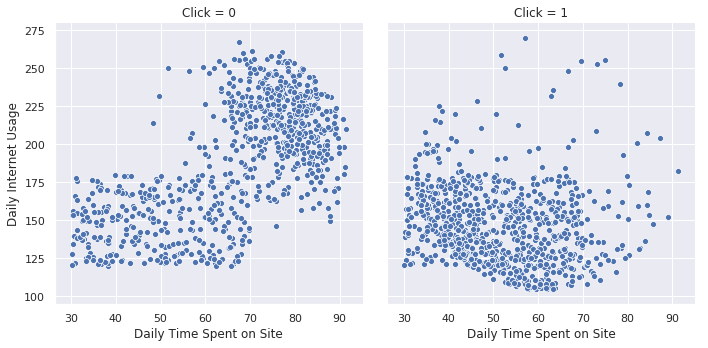

In [85]:
sns.relplot(x="Daily Time Spent on Site", y="Daily Internet Usage", col="Click", 
            data=advertising.toPandas())

In [86]:
advertising.show()

+--------------------+-----------------+-----+--------------------+--------------------+------------------------+---+----+----------------+
|            Ad_Topic|             City|Click|             Country|Daily Internet Usage|Daily Time Spent on Site| ID|Male|       Timestamp|
+--------------------+-----------------+-----+--------------------+--------------------+------------------------+---+----+----------------+
|Cloned 5thgenerat...|      Wrightburgh|    0|             Tunisia|              256.09|                   68.95|  1|   0|27-03-2016 00:53|
|Monitored nationa...|        West Jodi|    0|               Nauru|              193.77|                   80.23|  2|   1|04-04-2016 01:39|
|Organic bottom-li...|         Davidton|    0|          San Marino|               236.5|                   69.47|  3|   0|13-03-2016 20:35|
|Triple-buffered r...|   West Terrifurt|    0|               Italy|              245.89|                   74.15|  4|   1|10-01-2016 02:31|
|Robust logistical..

In [88]:
#merging Datasets
adNew = advertising.join(ad, on=['ID'], how='inner')

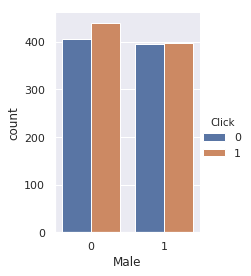

In [89]:
 sns.catplot(x="Male",hue="Click",data=adNew.toPandas(), kind="count",height=4,aspect=.7)


In [90]:
adNew.printSchema()

root
 |-- ID: long (nullable = true)
 |-- Ad_Topic: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Click: long (nullable = true)
 |-- Country: string (nullable = true)
 |-- Daily Internet Usage: double (nullable = true)
 |-- Daily Time Spent on Site: double (nullable = true)
 |-- Male: long (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Area Income: double (nullable = true)



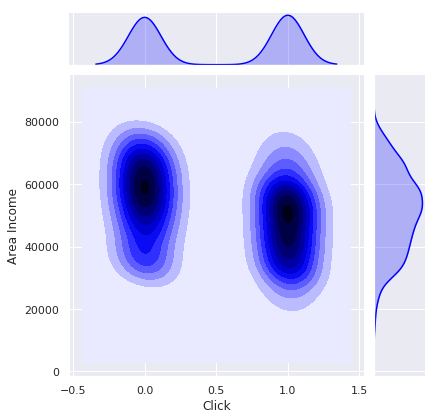

In [91]:
sns.jointplot(x="Click",y="Area Income",data=adNew.toPandas(), color = "blue", kind='kde')


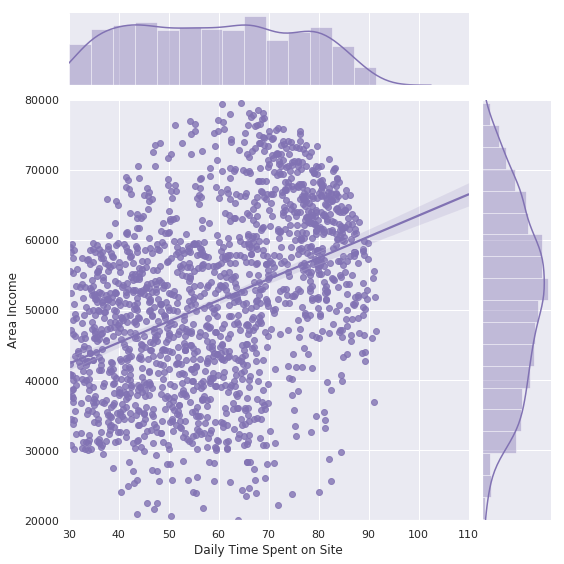

In [92]:
sns.set(style="darkgrid")


joint = sns.jointplot("Daily Time Spent on Site", "Area Income", data=adNew.toPandas(), kind="reg",
                  xlim=(30, 110), ylim=(20000,80000), color="m", height=8)

In [93]:
#Data Reduction
adNew.createOrReplaceTempView('data')
adNew = spark.sql("SELECT * FROM data")

In [94]:
adNew = spark.sql("SELECT * FROM data WHERE Age < 60")

In [95]:
adNew.count()

997

In [96]:
adNew = adNew.drop('City','Country')

In [97]:
#Data mining algorithms
from pyspark.ml.classification import LogisticRegression

In [98]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer,IndexToString)


In [99]:
#Converting String to numeric
AdTopic_Conversion = StringIndexer(inputCol='Ad_Topic',outputCol='adTopic').fit(adNew)
adNew = AdTopic_Conversion.transform(adNew)

adNew.show()

+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+
| ID|            Ad_Topic|Click|Daily Internet Usage|Daily Time Spent on Site|Male|       Timestamp|Age|Area Income|adTopic|
+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+
|  1|Cloned 5thgenerat...|    0|              256.09|                   68.95|   0|27-03-2016 00:53| 35|    61833.9|    5.0|
|  2|Monitored nationa...|    0|              193.77|                   80.23|   1|04-04-2016 01:39| 31|   68441.85|    8.0|
|  3|Organic bottom-li...|    0|               236.5|                   69.47|   0|13-03-2016 20:35| 26|   59785.94|    6.0|
|  4|Triple-buffered r...|    0|              245.89|                   74.15|   1|10-01-2016 02:31| 29|   54806.18|    7.0|
|  5|Robust logistical...|    0|              225.58|                   68.37|   0|03-06-2016 03:36| 35|   73889.99|    3.0|


In [100]:
#Creating bins
from pyspark.ml.feature import Bucketizer
bin = Bucketizer(splits=[ 0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 73, float('Inf') ],inputCol="adTopic", outputCol="Ad_bins")
adNew = bin.setHandleInvalid("keep").transform(adNew)

adNew.show()

+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+
| ID|            Ad_Topic|Click|Daily Internet Usage|Daily Time Spent on Site|Male|       Timestamp|Age|Area Income|adTopic|Ad_bins|
+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+
|  1|Cloned 5thgenerat...|    0|              256.09|                   68.95|   0|27-03-2016 00:53| 35|    61833.9|    5.0|    0.0|
|  2|Monitored nationa...|    0|              193.77|                   80.23|   1|04-04-2016 01:39| 31|   68441.85|    8.0|    1.0|
|  3|Organic bottom-li...|    0|               236.5|                   69.47|   0|13-03-2016 20:35| 26|   59785.94|    6.0|    1.0|
|  4|Triple-buffered r...|    0|              245.89|                   74.15|   1|10-01-2016 02:31| 29|   54806.18|    7.0|    1.0|
|  5|Robust logistical...|    0|              225.58|                

In [101]:
adNew.printSchema()

root
 |-- ID: long (nullable = true)
 |-- Ad_Topic: string (nullable = true)
 |-- Click: long (nullable = true)
 |-- Daily Internet Usage: double (nullable = true)
 |-- Daily Time Spent on Site: double (nullable = true)
 |-- Male: long (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Area Income: double (nullable = true)
 |-- adTopic: double (nullable = true)
 |-- Ad_bins: double (nullable = true)



In [102]:
bin = Bucketizer(splits=[ 0, 50, 100, 150, 200, 250, 300, float('Inf') ],inputCol="Daily Internet Usage", outputCol="Internet_Bins")
adNew = bin.setHandleInvalid("keep").transform(adNew)

adNew.show()

+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+-------------+
| ID|            Ad_Topic|Click|Daily Internet Usage|Daily Time Spent on Site|Male|       Timestamp|Age|Area Income|adTopic|Ad_bins|Internet_Bins|
+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+-------------+
|  1|Cloned 5thgenerat...|    0|              256.09|                   68.95|   0|27-03-2016 00:53| 35|    61833.9|    5.0|    0.0|          5.0|
|  2|Monitored nationa...|    0|              193.77|                   80.23|   1|04-04-2016 01:39| 31|   68441.85|    8.0|    1.0|          3.0|
|  3|Organic bottom-li...|    0|               236.5|                   69.47|   0|13-03-2016 20:35| 26|   59785.94|    6.0|    1.0|          4.0|
|  4|Triple-buffered r...|    0|              245.89|                   74.15|   1|10-01-2016 02:31| 29|   54806.18|  

In [103]:
#Train Test splitting
train_data, test_data = adNew.randomSplit([0.7,.3])

In [104]:
adNew = adNew.drop('Ad_Topic')

In [105]:
assembler = VectorAssembler(inputCols=['ID',
 'Age',
 'Daily Internet Usage',
 'Daily Time Spent on Site',
 'Internet_Bins',                                    
 'adTopic',                                   
 'Male',
 'Area Income'],outputCol='features')

In [106]:
#Logistic Regression
from pyspark.ml import Pipeline

In [107]:
lr = LogisticRegression(featuresCol='features',labelCol='Click')

In [108]:
pipeline_lr = Pipeline(stages=[assembler,lr])

In [109]:
train_data.show()
adNew.show()

+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+-------------+
| ID|            Ad_Topic|Click|Daily Internet Usage|Daily Time Spent on Site|Male|       Timestamp|Age|Area Income|adTopic|Ad_bins|Internet_Bins|
+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+-------------+
|  1|Cloned 5thgenerat...|    0|              256.09|                   68.95|   0|27-03-2016 00:53| 35|    61833.9|    5.0|    0.0|          5.0|
|  2|Monitored nationa...|    0|              193.77|                   80.23|   1|04-04-2016 01:39| 31|   68441.85|    8.0|    1.0|          3.0|
|  4|Triple-buffered r...|    0|              245.89|                   74.15|   1|10-01-2016 02:31| 29|   54806.18|    7.0|    1.0|          4.0|
|  6|Sharable client-d...|    0|              226.74|                   59.99|   1|19-05-2016 14:30| 23|   59761.56|  

In [110]:
fit_lr = pipeline_lr.fit(train_data)

In [111]:
results_lr = fit_lr.transform(test_data)

In [112]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictionLR = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Click')

In [113]:
results_lr.select('Click','prediction').show()

+-----+----------+
|Click|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows



In [114]:
lrClick =  np.array(results_lr.select("Click").collect())
lrPredict =  np.array(results_lr.select("prediction").collect())


In [115]:
accuracyLR = predictionLR.evaluate(results_lr)
print('Logistic Regression: {0:2.1f}%'.format(accuracyLR*100))
print("\nConfusion Matrix:\n",confusion_matrix(lrClick, lrPredict))


Logistic Regression: 97.0%

Confusion Matrix:
 [[129   4]
 [  5 160]]


In [121]:
#Decision Tree, Random forests, GBT
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier


In [122]:
assemblerDT = VectorAssembler(inputCols=['ID',
 'Age',
 'Daily Internet Usage',
 'Daily Time Spent on Site',
 'Ad_bins',                                      
 'Male',
 'Area Income'],outputCol='features')

In [123]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol = "Click")
rf = RandomForestClassifier(labelCol='Click',featuresCol='features')
gbt = GBTClassifier(labelCol='Click',featuresCol='features')

In [124]:
pipelineDT = Pipeline(stages=[assemblerDT, dt])
pipelineRF = Pipeline(stages=[assemblerDT, rf])
pipelineGBT = Pipeline(stages=[assemblerDT, gbt])

In [125]:
modelDT = pipelineDT.fit(train_data)
modelRF = pipelineRF.fit(train_data)
modelGBT = pipelineGBT.fit(train_data)

In [126]:
predictionDT = modelDT.transform(test_data)
predictionRF = modelRF.transform(test_data)
predictionGBT = modelGBT.transform(test_data)


In [127]:
predictionDT.select("prediction", "Click", "features").show(20)


+----------+-----+--------------------+
|prediction|Click|            features|
+----------+-----+--------------------+
|       0.0|    0|[3.0,26.0,236.5,6...|
|       0.0|    0|[5.0,35.0,225.58,...|
|       1.0|    1|[17.0,37.0,129.41...|
|       1.0|    1|[19.0,36.0,118.39...|
|       1.0|    1|[23.0,52.0,164.83...|
|       0.0|    0|[24.0,36.0,209.93...|
|       1.0|    1|[25.0,41.0,167.22...|
|       0.0|    0|[26.0,28.0,204.79...|
|       0.0|    0|[30.0,22.0,209.82...|
|       1.0|    1|[34.0,23.0,212.58...|
|       0.0|    0|[36.0,30.0,201.58...|
|       1.0|    1|[39.0,46.0,119.32...|
|       0.0|    0|[43.0,32.0,198.11...|
|       0.0|    0|[44.0,31.0,212.3,...|
|       0.0|    0|[52.0,28.0,225.29...|
|       1.0|    1|[54.0,50.0,133.2,...|
|       0.0|    0|[64.0,32.0,178.92...|
|       1.0|    1|[65.0,45.0,141.22...|
|       0.0|    0|[66.0,29.0,198.5,...|
|       1.0|    1|[70.0,34.0,131.72...|
+----------+-----+--------------------+
only showing top 20 rows



In [128]:
dtClick =  np.array(predictionDT.select("Click").collect())
dtPredict =  np.array(predictionDT.select("prediction").collect())


In [129]:
predictDT = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Click')
accuracyDT = predictDT.evaluate(predictionDT)
print('DT: {0:2.1f}%'.format(accuracyDT*100))
print('\n Confusion Matrix:\n',confusion_matrix(dtClick, dtPredict))

DT: 96.1%

 Confusion Matrix:
 [[129   4]
 [  8 157]]


In [130]:
predictionRF.select("prediction", "Click").show(20)



+----------+-----+
|prediction|Click|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
+----------+-----+
only showing top 20 rows



In [131]:
rfClick =  np.array(predictionRF.select("Click").collect())
rfPredict =  np.array(predictionRF.select("prediction").collect())


In [132]:
predictRF = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Click')
accuracyRF = predictRF.evaluate(predictionRF)
print('RF: {0:2.1f}%'.format(accuracyRF*100))
print('\nConfusion matrix:\n',confusion_matrix(rfClick, rfPredict))

RF: 96.0%

Confusion matrix:
 [[128   5]
 [  7 158]]


In [133]:
predictionGBT.select("prediction", "Click").show(20)


+----------+-----+
|prediction|Click|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
+----------+-----+
only showing top 20 rows



In [134]:
gbtClick =  np.array(predictionGBT.select("Click").collect())
gbtPredict =  np.array(predictionGBT.select("prediction").collect())


In [135]:
predictGBT = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Click')
accuracyGBT = predictGBT.evaluate(predictionGBT)
print('GBT: {0:2.1f}%'.format(accuracyGBT*100))
print("\nConfusion Matrix:\n",confusion_matrix(gbtClick, gbtPredict))

GBT: 96.3%

Confusion Matrix:
 [[128   5]
 [  6 159]]


In [136]:
#Naive Bayes
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [137]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", featuresCol='features', labelCol='Click', predictionCol='prediction', probabilityCol='probability')


In [138]:
pipelineNB = Pipeline(stages=[assemblerDT, nb])


In [139]:
modelNB = pipelineNB.fit(train_data)


In [140]:
predictionNB = modelNB.transform(test_data)


In [141]:
predictionNB.select("prediction", "Click").show(20)

+----------+-----+
|prediction|Click|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    1|
+----------+-----+
only showing top 20 rows



In [142]:
evaluatorNB = MulticlassClassificationEvaluator(labelCol="Click", predictionCol="prediction",
                                              metricName="accuracy")

In [143]:
accuracyNB = evaluatorNB.evaluate(predictionNB)
print('NB: {0:2.1f}%'.format(accuracyNB*100))

NB: 62.1%


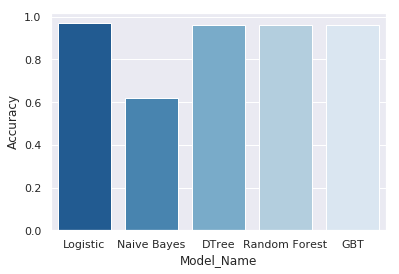

In [144]:
scores = [('Logistic',accuracyLR),('Naive Bayes',accuracyNB),('DTree',accuracyDT),
          ('Random Forest',accuracyRF),('GBT',accuracyGBT)]
graph=spark.createDataFrame(scores, ["Model_Name","Accuracy"])
graph
sns.barplot(x="Model_Name", y="Accuracy", data=graph.toPandas(), palette="Blues_r")

In [145]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


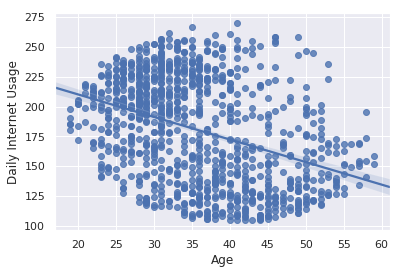

In [146]:
sns.regplot('Age','Daily Internet Usage', data= adNew.toPandas())

In [147]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

c = { 2.0: "low", 3.0:"med", 4.0: "high", 5.0 :"V.high"}
IB = udf(lambda x: c[x], StringType())
finalData = adNew.withColumn("Internet_Usage", IB("Internet_Bins"))

In [69]:
finalData.show()

+---+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+-------------+--------------+
| ID|Click|Daily Internet Usage|Daily Time Spent on Site|Male|       Timestamp|Age|Area Income|adTopic|Ad_bins|Internet_Bins|Internet_Usage|
+---+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+-------------+--------------+
|  1|    0|              256.09|                   68.95|   0|27-03-2016 00:53| 35|    61833.9|    5.0|    0.0|          5.0|        V.high|
|  2|    0|              193.77|                   80.23|   1|04-04-2016 01:39| 31|   68441.85|    8.0|    1.0|          3.0|           med|
|  3|    0|               236.5|                   69.47|   0|13-03-2016 20:35| 26|   59785.94|    6.0|    1.0|          4.0|          high|
|  4|    0|              245.89|                   74.15|   1|10-01-2016 02:31| 29|   54806.18|    7.0|    1.0|          4.0|          high|
|  5|    0|  

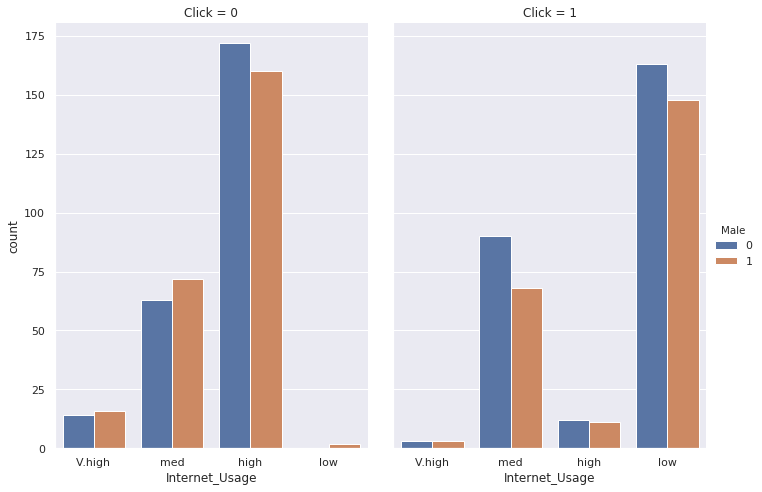

In [70]:
visualize_1 = sns.catplot(x="Internet_Usage",hue="Male", col = 'Click',data=finalData.toPandas(), kind="count",height=7,aspect=.7)
